# Patient Transport Modelling

This notebook provides an overview and instructions to run the patient transport model and explore results.

## Aims of the modelling

The model can be used to explore the impact of increasing transport vehicle (e.g. an ambulance) capacity on the total one-way travel time  needed.  We estimate two-way travel time via a simplification: doubling the one-way travel time.

**Please note that**:

* The modelling is not intended to provide guidance on the number of vehicles needed.    
* Travel time excludes vehicle turnaround time after each trip, duration of pickup and breaks rests for drivers.  


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## The VRP package

The python `VRP` package provides functions and classes to:

* Generate a simple weighted sample of a patient population spread over a geographic area.
* Construct multiple short (but not necessarily optimal) routes for transport vehicles, with a given capacity, to travel to each patient from a 'treatment facility' and return.
* Quickly generate a large dataset of samples through parallel simulation.

### Geospatial and travel time data

The first step in parameterising a model is to load the input data files

* Patient count by postcode sector
* Travel times between each postcode sector

The data used in the analysis can be done access via functions in the module

```python
vrp.io
```

Note the example here uses travel time.  But travel distance could also be used.

In [2]:
from vrp.io import (load_patient_postcode_count, 
                    load_travel_time)

In [3]:
cost_matrix = load_travel_time()
sector_counts = load_patient_postcode_count()

These functions each return a `pandas.DataFrame`

In [4]:
type(cost_matrix)

pandas.core.frame.DataFrame

In [5]:
cost_matrix.shape

(262, 262)

In [6]:
type(sector_counts)

pandas.core.frame.DataFrame

In [7]:
sector_counts.head(3)

,count
sector,
L151,1
L91,2
L31,1


### Built-in preprocessing

To convert a distribution of patient counts by postcodes to proportions use the following function 

In [8]:
from vrp.sim import create_postcode_distribution

In [9]:
postcode_distribution = create_postcode_distribution(sector_counts)

In [10]:
type(postcode_distribution)

pandas.core.frame.DataFrame

In [11]:
postcode_distribution.head(3)

,count,prob
sector,,
L151,1,0.001919
L91,2,0.003839
L31,1,0.001919


### Running a transport experiment and exploring results

This can be done via six classes representing an simulated experiment, a scenario and a vehicle routing solvers.

```python
vrp.sim.TransportExperiment
vrp.sim.Scenario
vrp.sim.ILSWithConstructive
vrp.constructive.SequentialClarkeWright
vrp.sim.MultipleReplicationRunner
vrp.sim.ScenarioManager
```
`TransportExperiment` is a stochastic model.  It generates a sample of the patient population to transport and then creates routes for patient transport services to use.

`Scenario` is a python `dataclass`.  It is used to set the parameters for the simulation and passed to a `TransportExperiment`

`ILSWithConstructive` is a class that combines a simple constructive heuristic with Iterated Local Search

`SequentialClarkeWright` is a constructive heuristic based for building transport routes based on the Clarke-Wright Savings algorithm.

`MultipleReplicationRunner` allows a user to run multiple parallel replications of a simulation experiment.

`ScenarioManager` allows a user to run multiple parallel replications of multiple scenarios

#### **Step 1: create a scenario**

A `Scenario` accepts the following arguments

* n_patients: int, the number of patients to sample.
* warehouse: str or int, the location of the depot/warehouse/facility where the vehicles start and end their trips.
* vehicle_capacities: list, e.g [2, 3, 4].  
* cost_matrix: pandas.DataFrame, A travel distance or travel time matrix between all locations.
* postcode_distribution: pandas.DataFrame, the distribution of patients by postcode.
* p_positive: float, the probability a sampled patient is positive 
* p_transport: float, the probability a sampled patient required transport

In [12]:
#import the Scenario data class
from vrp.sim import Scenario

In [13]:
HOSP_LOCATION = 'L51'
N_PATIENTS = 15
CAPACITIES = [2, 3, 4]
P_POS = 1.0
P_TRAN = 1.0

#sim parameters
scenario_15 = Scenario(n_patients=N_PATIENTS,
                       warehouse=HOSP_LOCATION,
                       vehicle_capacities=CAPACITIES,
                       cost_matrix = cost_matrix,
                       postcode_distribution=postcode_distribution,
                       p_positive=P_POS, 
                       p_transport=P_TRAN)

#### **Step 2: create a Vehicle Routing Solver**

In [14]:
#import the Clark-Wright Savings euristic and ILS/Constructive wrapper classes
from vrp.constructive import SequentialClarkeWright
from vrp.sim import ILSWithConstructive

In [15]:
N_ITER = 20
solver = ILSWithConstructive(constructive=SequentialClarkeWright(HOSP_LOCATION),
                             warehouse=HOSP_LOCATION, 
                             iterations=N_ITER)

#### **Step 3: Create a transport experiment**

In [16]:
#import the TransportExperiment class
from vrp.sim import TransportExperiment

In [17]:
model = TransportExperiment(scenario=scenario_15, 
                            solver=solver)

#### **Step 3: Test run a single experiment**

This should execute in < 1 second.

In [18]:
#set random seed to get a reproducible run
SEED = 19
np.random.seed(SEED)

result = model.single_replication()

In [19]:
#the result is a python dict with total travel time by capacity of vehicle
result

{'capacity_1': 962,
 'capacity_2': 630.0,
 'capacity_3': 494.0,
 'capacity_4': 463.0}

#### **Step 4: Execute multiple independent replications in parallel**

It will take several seconds to run 10 replications. Depending on the population size, number of ILS iterations, and number of replications runtime can vary from seconds to hours.

In [20]:
from vrp.sim import MultipleReplicationRunner

In [21]:
runner = MultipleReplicationRunner(model=model, random_state=SEED)

In [22]:
N_REPS = 10
results = runner.execute(n_reps=N_REPS)

In [23]:
#results is a list of dicts
type(results)

list

In [24]:
results[0]

{'capacity_1': 974.0,
 'capacity_2': 643.0,
 'capacity_3': 528.0,
 'capacity_4': 505.0}

In [25]:
#convert results to a pandas DataFrame
df_results = pd.DataFrame(results)

In [26]:
df_results.head(3)

,capacity_1,capacity_2,capacity_3,capacity_4
0,974.0,643.0,528.0,505.0
1,1140.0,707.0,613.0,492.0
2,712.0,505.0,411.0,393.0


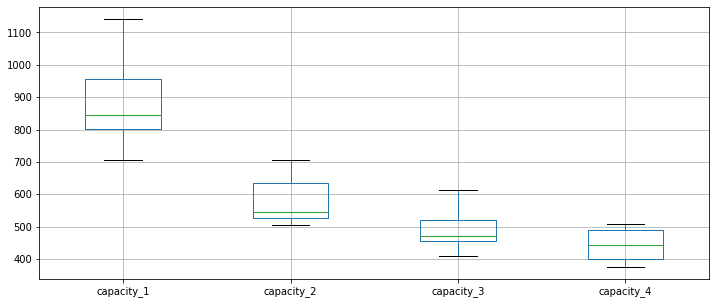

In [27]:
#y-acis is in minutes in this example, but could be travel distance
df_results.boxplot(figsize=(12,5))

#### **Step 5: Analyse multiple scenarios**

First create multiple scenario objects

In [28]:
HOSP_LOCATION = 'L51'
CAPACITIES = [2, 3, 4]
P_POS = 1.0
P_TRAN = 1.0

#scenario where 15 patients are positive on a day
scenario_15 = Scenario(n_patients=15,
                       warehouse=HOSP_LOCATION,
                       vehicle_capacities=CAPACITIES,
                       cost_matrix = cost_matrix,
                       postcode_distribution=postcode_distribution,
                       p_positive=P_POS, 
                       p_transport=P_TRAN)

#scenario where 25 patients are positive on a day
scenario_25 = Scenario(n_patients=25,
                       warehouse=HOSP_LOCATION,
                       vehicle_capacities=CAPACITIES,
                       cost_matrix = cost_matrix,
                       postcode_distribution=postcode_distribution,
                       p_positive=P_POS, 
                       p_transport=P_TRAN)

#store these in a dict
scenarios = {}
scenarios['15_covid_positive'] = scenario_15
scenarios['25_covid_positive'] = scenario_25

In [29]:
#create a sce
from vrp.sim import ScenarioManager

In [30]:
SEED = 999
manager = ScenarioManager(scenarios, solver, random_state=SEED)

In [31]:
scenario_results = manager.execute(N_REPS)

Running scenario: 15_covid_positive... done.
Running scenario: 25_covid_positive... done.
All experiments completed.


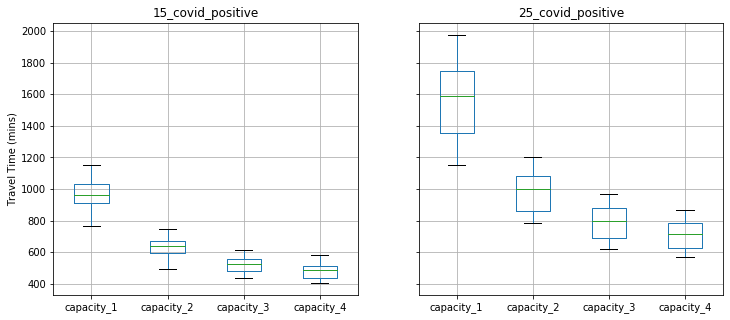

In [32]:
#plot multiple scenarios in one figure
fig, ax = plt.subplots(1, 2, figsize=(12,5), sharey=True)
index = 0
for scenario_name, result in scenario_results.items():
    result.boxplot(ax=ax[index])
    ax[index].set_title(scenario_name)
    index += 1
    
ax[0].set_ylabel('Travel Time (mins)');

#uncomment to save to file...
#fig.savefig('scenario_boxplots.png', dpi=300)

In [33]:
#access one of the scenarios
scenario_results['25_covid_positive']

#uncomment to save results to file
#scenario_results['25_covid_positive'].to_csv('single_scenario_result.csv')

,capacity_1,capacity_2,capacity_3,capacity_4
0,1306.0,834.0,681.0,586.0
1,1562.0,976.0,771.0,706.0
2,1618.0,1059.0,868.0,750.0
3,1896.0,1175.0,883.0,799.0
4,1756.0,1027.0,827.0,724.0
5,1250.0,798.0,618.0,571.0
6,1732.0,1095.0,921.0,854.0
7,1972.0,1201.0,966.0,870.0
8,1514.0,942.0,720.0,661.0
9,1150.0,784.0,681.0,619.0


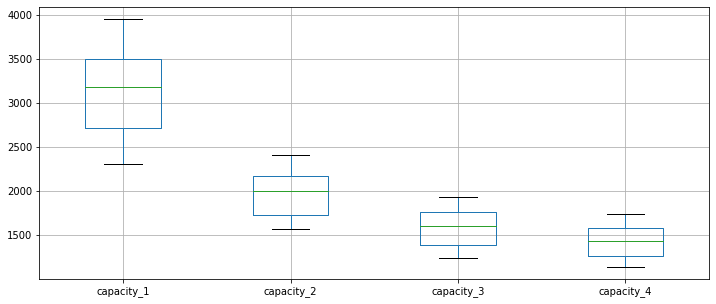

In [34]:
### Doubling travel times
two_way = scenario_results['25_covid_positive'] * 2
two_way.boxplot(figsize=(12,5))